venv:
- conda create -n pinn python=3
- conda activate pinn
- conda install jupyter numpy matplotlib
- conda install pytorch torchvision torchaudio -c pytorch

In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [42]:
# Use cuda if available (use model.to(device) to run on device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
print(torch.version.cuda)         # Shows CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Should be True if GPU is usable

12.1
True


In [44]:
class Model(nn.Module):
    # defines a fully connected neural network, with a tanh activation function
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        act_f = nn.Tanh

        # First layer, "*" unpacks the list into arguments of nn.Sequential
        self.fcs = nn.Sequential(*[
                        nn.Linear(inputs, hidden),
                        act_f()])
        
        # Hidden layers with activation function
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden, hidden),
                            act_f()]) for _ in range(n_layers-1)])
        
        # Final layer that maps from last hidden layer to output size
        self.fce = nn.Linear(hidden, outputs)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Done step 0
Done step 50000
Done step 100000
Done step 150000


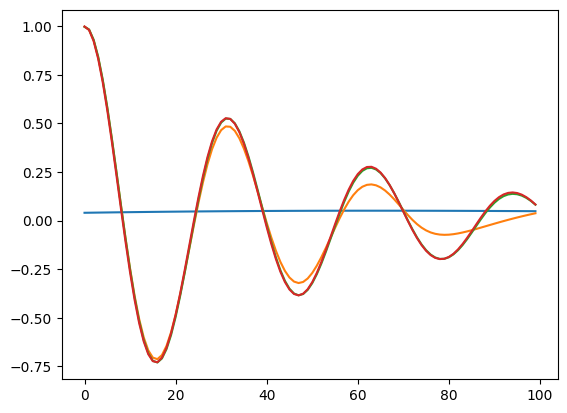

In [ ]:
# 1D spring simulation:
d, w0 = 2, 20 # Conditions for an under-dampened spring
mu, k = 2*d, w0**2

torch.manual_seed(42)
#model with 1 input and output layers (time and amplitude) and 4 hidden layers of 42 neurons
spring_model = Model(1, 1, 42, 4).to(device)
optimizer = torch.optim.Adam(spring_model.parameters(),lr=1e-4)

x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # generate time inputs
x_physics = x_physics.to(device)

last_res = np.array(0)

for i in range(150001):
    optimizer.zero_grad()
    
    # compute the "physics loss"
    yhp = spring_model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss_phys = (1e-4)*torch.mean(physics**2)

    #If time is 0, we want an amplitude of 1 (boundary condition)
    loss_BC = abs(1-yhp[0])
    
    # backpropagate joint loss
    loss = loss_phys + loss_BC# add two loss terms together
    loss.backward()
    optimizer.step()

    if i%50000 == 0:
        print(f"Done step {i}")
        to_display = yhp.cpu()
        to_display = to_display.detach().numpy()
        last_res = to_display
        plt.plot(to_display)



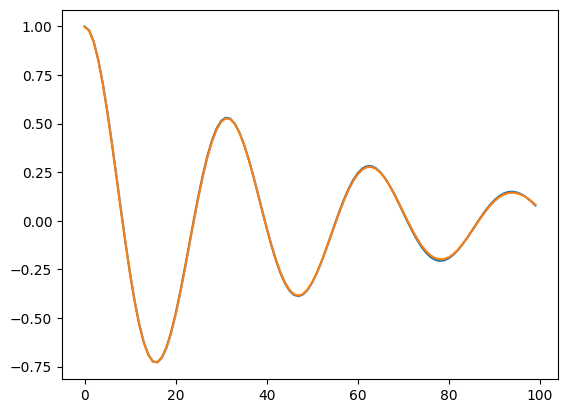

In [47]:
# Real spring, just to compare
def oscillator(d, w0, x):
    assert d < w0 # check if really underdampened
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

x = torch.linspace(0,1,100).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

plt.plot(y)
plt.plot(last_res)